In [29]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import os

plt.rcParams.update({
    'font.size': 6,               # Default text size
    'axes.titlesize': 6,          # Title size for axes
    'axes.labelsize': 6,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 6,        # Overall figure title size
})
MODEL_NAME = 'gemma-2-9b'

# Scarcity

In [30]:
def read_results_scarcity(regime = 'scarcity', method = None):
    df = pd.read_csv(f'results/baseline_probes_{MODEL_NAME}/{regime}/summary/all_results.csv')
    if method is not None:
        return df[df['method'] == method]
    return df

def read_saes_scarcity(setting = 'scarcity', saeid = None):
    df = pd.read_csv(f'results/sae_probes_{MODEL_NAME}/{setting}_setting/all_metrics.csv')
    #df = df[df['k'] == 128]
    df['method'] = 'sae_' + df['sae_id'] + '_k' + df['k'].astype(str)
    if saeid is not None:
        df = df[df['sae_id'].str.contains(saeid)]
    df = df[['test_f1', 'test_acc', 'test_auc', 'val_auc', 'dataset', 'method', 'num_train']]
    #df = df[df['method'].str.contains('1m')]
    return df

def get_all_scarcity(ret = ['baseline', 'sae']):
    dfs = []
    if 'baseline' in ret:
        dfs.append(read_results_scarcity())
    if 'sae' in ret:
        dfs.append(read_saes_scarcity())
    if len(dfs) == 0:
        raise ValueError('should never be here')
    return pd.concat(dfs, ignore_index=True)

def quiver_arrows_scarcity(sae = False):
    ret = ['baseline']
    if sae:
        ret = ['sae', 'baseline']
    df = get_all_scarcity(ret)
    # Group by dataset and num_train, keep only row with highest val_auc
    # For ties, prefer rows with 'sae' in method name
    df['has_sae'] = df['method'].str.contains('sae')
    df['width_rank'] = df['method'].apply(lambda x: 
        1 if 'width_16k' in str(x) else
        2 if 'width_131k' in str(x) else 
        3 if 'width_1m' in str(x) else 4)
    df['k_rank'] = df['method'].apply(lambda x:
        1 if 'k128' in str(x) else
        2 if 'k16' in str(x) else 3)
    df = df.sort_values('has_sae', ascending=False)
    df = df.loc[df.groupby(['dataset', 'num_train'])['val_auc'].idxmax()]
    return df[['test_f1', 'test_acc', 'test_auc', 'val_auc','method', 'num_train', 'dataset']]


# Imbalance

In [31]:
def read_results_imbalance(method = None):
    df = pd.read_csv(f'results/baseline_probes_{MODEL_NAME}/imbalance/all_results.csv')
    df['ratio'] = df['ratio'].round(2) # Round to 2 decimal places first 
    df['ratio'] = (df['ratio'] * 20).round() / 20 # Round to nearest 0.05
    if method is not None:
        return df[df['method'] == method]#[['test_f1', 'test_acc', 'test_auc', 'val_auc','method', 'ratio']]
    return df

def read_sae_imbalance(saeid = None):
    df = pd.read_csv(f'results/sae_probes_{MODEL_NAME}/class_imbalance_setting/all_metrics.csv')
    df = df.rename(columns={'frac': 'ratio'})
    df['ratio'] = df['ratio'].round(2) # Round to 2 decimal places first 
    df['ratio'] = (df['ratio'] * 20).round() / 20 # Round to nearest 0.05
    df['method'] = 'sae_' + df['sae_id'] + '_k' + df['k'].astype(str)
    if saeid is not None:
        df = df[df['sae_id'].str.contains(saeid)]
    df = df[['test_f1', 'test_acc', 'test_auc', 'val_auc','method', 'ratio', 'dataset']]
    return df.reset_index(drop = True)

def get_all_imbalance(ret = ['baseline', 'sae']):
    dfs = []
    if 'baseline' in ret:
        dfs.append(read_results_imbalance())
    if 'sae' in ret:
        dfs.append(read_sae_imbalance())
    if len(dfs) == 0:
        raise ValueError('should never be here')
    return pd.concat(dfs, ignore_index=True)

def quiver_arrows_imbalance(sae = False):
    ret = ['baseline']
    if sae:
        ret = ['baseline', 'sae']
    df = get_all_imbalance(ret)
    # Group by dataset and num_train, keep only row with highest val_auc
    # For ties, prefer rows with 'sae' in method name
    df['has_sae'] = df['method'].str.contains('sae')
    df['width_rank'] = df['method'].apply(lambda x: 
        1 if 'width_16k' in str(x) else
        2 if 'width_131k' in str(x) else 
        3 if 'width_1m' in str(x) else 4)
    df['k_rank'] = df['method'].apply(lambda x:
        1 if 'k128' in str(x) else
        2 if 'k16' in str(x) else 3)
    df = df.sort_values('has_sae', ascending=False)
    df = df.loc[df.groupby(['dataset', 'ratio'])['val_auc'].idxmax()]
    return df[['test_f1', 'test_acc', 'test_auc', 'val_auc','method', 'ratio', 'dataset']]


# Normal helpers
Mostly for comparing non quiver to quiver

In [32]:
def read_layer_normal(layer = 20):
    return pd.read_csv(f'results/baseline_probes_{MODEL_NAME}/normal_settings/layer{layer}_results.csv')
def read_saes_normal():
    df = pd.read_csv('results/sae_probes_gemma-2-9b/normal_setting/all_metrics.csv')
    
    # Extract layer, width and l0 from sae_id using raw strings to fix escape sequence warnings
    df['method'] = df['sae_id']
    df['layer'] = df['method'].str.extract(r'layer_(\d+)').astype(int)
    df['width'] = df['method'].str.extract(r'width_(\d+k|1m)').astype(str)
    df['l0'] = df['method'].str.extract(r'l0_(\d+)').astype(int)
    
    # Filter to only keep k=16/128 and specific widths
    df = df[df['k'].isin([16, 128])]
    df = df[df['width'].isin(['16k', '131k', '1m'])]
    
    # For each layer/width combo, keep only row with highest l0
    df = df.sort_values('l0', ascending=False)
    df = df.drop_duplicates(subset=['layer', 'width', 'dataset', 'k'], keep='first')
    
    # Add k to method name
    df['method'] = df['method'] + '_k' + df['k'].astype(str)
    
    # Drop the extra columns we added
    df = df.drop(['layer', 'width', 'l0'], axis=1)
    
    return df

def get_all_normal(ret = ['baseline', 'sae']):
    dfs = []
    if 'baseline' in ret:
        dfs.append(read_layer_normal())
    if 'sae' in ret:
        dfs.append(read_saes_normal())
    if len(dfs) == 0:
        raise ValueError('should never be here')
    return pd.concat(dfs, ignore_index=True)

def arrow_quiver_normal(sae = False):

    # does the quiver of arrows approach. we first
    # use sae = False to see how baselines do alone
    # and then see how our approach does when
    # SAEs are added back into the mix
    ret = 'baseline'
    if sae:
        ret = ['sae', 'baseline']
    df = get_all_normal(ret)
    best_methods = df.loc[df.groupby('dataset')['val_auc'].idxmax()]
    return best_methods.reset_index(drop=True)
get_all_normal()

,dataset,method,test_f1,test_acc,test_auc,val_auc,k,sae_id,reg_type,binarize
0,5_hist_fig_ismale,logreg,0.979376,0.979376,0.993974,0.999600,NaN,NaN,NaN,NaN
1,5_hist_fig_ismale,pca,0.975101,0.975101,0.993966,0.997599,NaN,NaN,NaN,NaN
2,5_hist_fig_ismale,knn,0.876987,0.877012,0.945927,0.914566,NaN,NaN,NaN,NaN
3,5_hist_fig_ismale,xgboost,0.954213,0.954214,0.988623,0.989196,NaN,NaN,NaN,NaN
4,5_hist_fig_ismale,mlp,0.977358,0.977358,0.993637,0.999600,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1238,146_disease_class_cardiovascular diseases,layer_20/width_1m/average_l0_193_k128,0.736836,0.737374,0.802449,0.851717,128.0,layer_20/width_1m/average_l0_193,l1,False
1239,146_disease_class_cardiovascular diseases,layer_20/width_1m/average_l0_193_k16,0.614984,0.616162,0.691837,0.791111,16.0,layer_20/width_1m/average_l0_193,l1,False
1240,22_headline_isobama,layer_20/width_1m/average_l0_193_k128,0.874784,0.874802,0.948614,0.960784,128.0,layer_20/width_1m/average_l0_193,l1,False
1241,22_headline_isobama,layer_20/width_1m/average_l0_193_k16,0.854195,0.854200,0.927075,0.939976,16.0,layer_20/width_1m/average_l0_193,l1,False


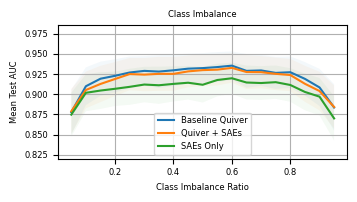

In [33]:
def plot_quiver_comp(target = 'Class Imbalance'):
    # plots comparison between using quiver and just use saes only
    metrics = {'Class Imbalance': 'ratio', 'Data Scarcity': 'num_train'}
    metric_labels = {'Class Imbalance': 'Class Imbalance Ratio', 'Data Scarcity': 'Number of Training Examples'}
    if target == 'Class Imbalance':
        saeonly = get_all_imbalance(ret = ['sae'])
        baselineonly = quiver_arrows_imbalance(sae = False)
        saequiver = quiver_arrows_imbalance(sae = True)
    elif target == 'Data Scarcity':
        saeonly = get_all_scarcity(ret = ['sae'])
        baselineonly = quiver_arrows_scarcity(sae = False)
        saequiver = quiver_arrows_scarcity(sae = True)

    
    labels = ['Baseline Quiver', 'Quiver + SAEs', 'SAEs Only']
    
    plt.figure(figsize=(3.5,2))
    
    all_means = []
    for df, label in zip([baselineonly, saequiver, saeonly], labels):
        # Group by dataset and ratio, get max val_auc row for each group
        df_max = df.loc[df.groupby(['dataset', metrics[target]])['val_auc'].idxmax()]
        
        # Calculate mean and 95% CI for test_auc for each ratio
        grouped = df_max.groupby(metrics[target])['test_auc']
        mean_by_ratio = grouped.mean()
        n = grouped.count()
        ci_by_ratio = 1.96 * grouped.std() / np.sqrt(n)
        all_means.extend(mean_by_ratio.values)
        
        if target == 'Data Scarcity':
            x_values = np.arange(len(mean_by_ratio))
            plt.plot(x_values, mean_by_ratio.values, label=label, lw = 1.5)
            plt.fill_between(x_values,
                            mean_by_ratio.values - ci_by_ratio.values,
                            mean_by_ratio.values + ci_by_ratio.values,
                            alpha=0.05)
        else:
            plt.plot(mean_by_ratio.index, mean_by_ratio.values, label=label, lw = 1.5)
            plt.fill_between(mean_by_ratio.index,
                            mean_by_ratio.values - ci_by_ratio.values,
                            mean_by_ratio.values + ci_by_ratio.values,
                            alpha=0.05)
    
    plt.xlabel(metric_labels[target])
    plt.ylabel('Mean Test AUC')
    plt.title(target)
    plt.legend()
    plt.grid(True)
    
    # Set ylim based on mean values only
    ymin = min(all_means)
    ymax = max(all_means)
    plt.ylim(max(0.5, ymin - 0.05), min(1.0, ymax + 0.05))
    
    if target == 'Data Scarcity':
        plt.xticks(np.arange(len(mean_by_ratio)), mean_by_ratio.index)
    
    plt.tight_layout()
    
    # Save plots
    plt.savefig(f'figures/combined/{target}_noquiver_comp.pdf')
    plt.savefig(f'figures/combined/{target}_noquiver_comp.png')
    plt.show()
plot_quiver_comp('Class Imbalance')

Standard Conditions

All means: [0.9399762998876823, 0.9366557775652804, 0.9413958567404387, 0.9037783048521237, 0.9209599468211078, 0.8988206465885017, 0.9182129897511194, 0.888718288828038, 0.913018955392272]
All labels: ['Baseline Quiver', 'Quiver + SAEs', 'LogReg', 'SAE width=16k, k=16', 'SAE width=16k, k=128', 'SAE width=131k, k=16', 'SAE width=131k, k=128', 'SAE width=1m, k=16', 'SAE width=1m, k=128']


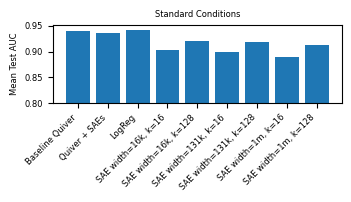

Data Scarcity

All means: [0.8193008174211762, 0.8149645768930227, 0.8357580848884154, 0.7936186032453183, 0.8133831244224865, 0.7939278054005526, 0.810073267496606, 0.7840441700261422, 0.8025400297823142]
All labels: ['Baseline Quiver', 'Quiver + SAEs', 'LogReg', 'SAE width=16k, k=16', 'SAE width=16k, k=128', 'SAE width=131k, k=16', 'SAE width=131k, k=128', 'SAE width=1m, k=16', 'SAE width=1m, k=128']


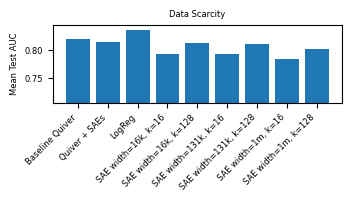

Class Imbalance

All means: [0.9211462783847373, 0.9180974033881745, 0.9294006953689179, 0.8869514827247444, 0.9108688693635959, 0.8827401668578936, 0.9051487572415677, 0.8739594612121945, 0.9003552931398826]
All labels: ['Baseline Quiver', 'Quiver + SAEs', 'LogReg', 'SAE width=16k, k=16', 'SAE width=16k, k=128', 'SAE width=131k, k=16', 'SAE width=131k, k=128', 'SAE width=1m, k=16', 'SAE width=1m, k=128']


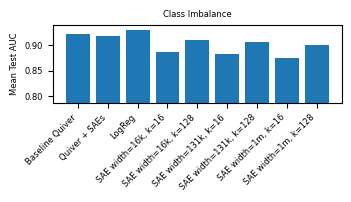

In [34]:
def plot_quiver_comp(target = 'Class Imbalance'):
    # plots comparison between using quiver and just use saes only
    metrics = {'Class Imbalance': 'ratio', 'Data Scarcity': 'num_train'}
    metric_labels = {'Class Imbalance': 'Class Imbalance Ratio', 'Data Scarcity': 'Number of Training Examples'}
    if target == 'Class Imbalance':
        saeonly = get_all_imbalance(ret = ['sae'])
        baselineonly = get_all_imbalance(ret = ['baseline'])
        baselinequiver = quiver_arrows_imbalance(sae = False)
        saequiver = quiver_arrows_imbalance(sae = True)
    elif target == 'Data Scarcity':
        saeonly = get_all_scarcity(ret = ['sae'])
        baselineonly = get_all_scarcity(ret = ['baseline'])
        baselinequiver = quiver_arrows_scarcity(sae = False)
        saequiver = quiver_arrows_scarcity(sae = True)
    elif target == 'Standard Conditions':
        saeonly = get_all_normal(ret = ['sae'])
        baselineonly = get_all_normal(ret = ['baseline'])
        baselinequiver = arrow_quiver_normal(sae = False)
        saequiver = arrow_quiver_normal(sae = True)

    # Get mean test_auc for each method
    means = []
    labels = []
    
    # Add baseline quiver mean
    means.append(baselinequiver['test_auc'].mean())
    labels.append('Baseline Quiver')
    
    # Add SAE quiver mean  
    means.append(saequiver['test_auc'].mean())
    labels.append('Quiver + SAEs')
    
    # Add baseline logreg mean
    baseline_logreg = baselineonly[baselineonly['method'] == 'logreg']
    means.append(baseline_logreg['test_auc'].mean())
    labels.append('LogReg')
    
    # Add individual SAE means in order of width then k
    widths = ['16k', '131k', '1m']
    ks = [16, 128]
    
    for width in widths:
        for k in ks:
            method = [m for m in saeonly['method'].unique() if width in m and f'_k{k}' in m]
            if method:  # Only add if this width/k combination exists
                mean_val = saeonly[saeonly['method'] == method[0]]['test_auc'].mean()
                means.append(mean_val)
                labels.append(f'SAE width={width}, k={k}')
                #print(f"Method: {labels[-1]}, Mean test AUC: {mean_val:.3f}")
    print(target)
    print("\nAll means:", means)
    print("All labels:", labels)
    plt.figure(figsize=(3.5,2))
    x = np.arange(len(means))
    plt.bar(x, means)
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.ylabel('Mean Test AUC')
    plt.title(target)
    #plt.grid(True, axis='y')
    plt.ylim((min(means)*0.9, max(means)*1.01))
    plt.tight_layout()
    
    # Save plots
    plt.savefig(f'figures/combined/{target}_bar_comp.pdf')
    plt.savefig(f'figures/combined/{target}_bar_comp.png')
    plt.show()
for target in ['Standard Conditions', 'Data Scarcity', 'Class Imbalance']:
    plot_quiver_comp(target)

# Corrupt data

In [35]:
def read_results_corrupt(method = None):
    df = pd.read_csv(f'results/baseline_probes_{MODEL_NAME}/corrupt/all_results.csv')
    df['ratio'] = df['ratio'].round(2) # Round to 2 decimal places first 
    df['ratio'] = (df['ratio'] * 20).round() / 20 # Round to nearest 0.05
    df = df[['test_f1', 'test_acc', 'test_auc', 'val_auc','method', 'ratio', 'dataset']]
    if method is not None:
        return df[df['method'] == method]
    return df

def read_sae_corrupt():
    df = pd.read_csv(f'results/sae_probes_{MODEL_NAME}/label_noise_setting/all_metrics.csv')
    df = df.rename(columns={'corrupt_frac': 'ratio'})
    df['ratio'] = df['ratio'].round(2) # Round to 2 decimal places first 
    df['ratio'] = (df['ratio'] * 20).round() / 20 # Round to nearest 0.05
    df['method'] = 'sae_' + df['sae_id'] + '_k' + df['k'].astype(str)
    df = df[df['method'] == 'sae_layer_20/width_16k/average_l0_408_k128'] #'sae_layer_20/width_1m/average_l0_193_k128']
    df = df[['test_f1', 'test_acc', 'test_auc', 'val_auc','method', 'ratio', 'dataset']]
    return df.reset_index(drop = True)

def quiver_arrows_corrupt(sae = False):
    # for corrupt sae, we dont do quiver of arrows
    if sae:
        return read_sae_corrupt()
    else:
        return read_results_corrupt()


# Plot dataset imshows for all three conditions

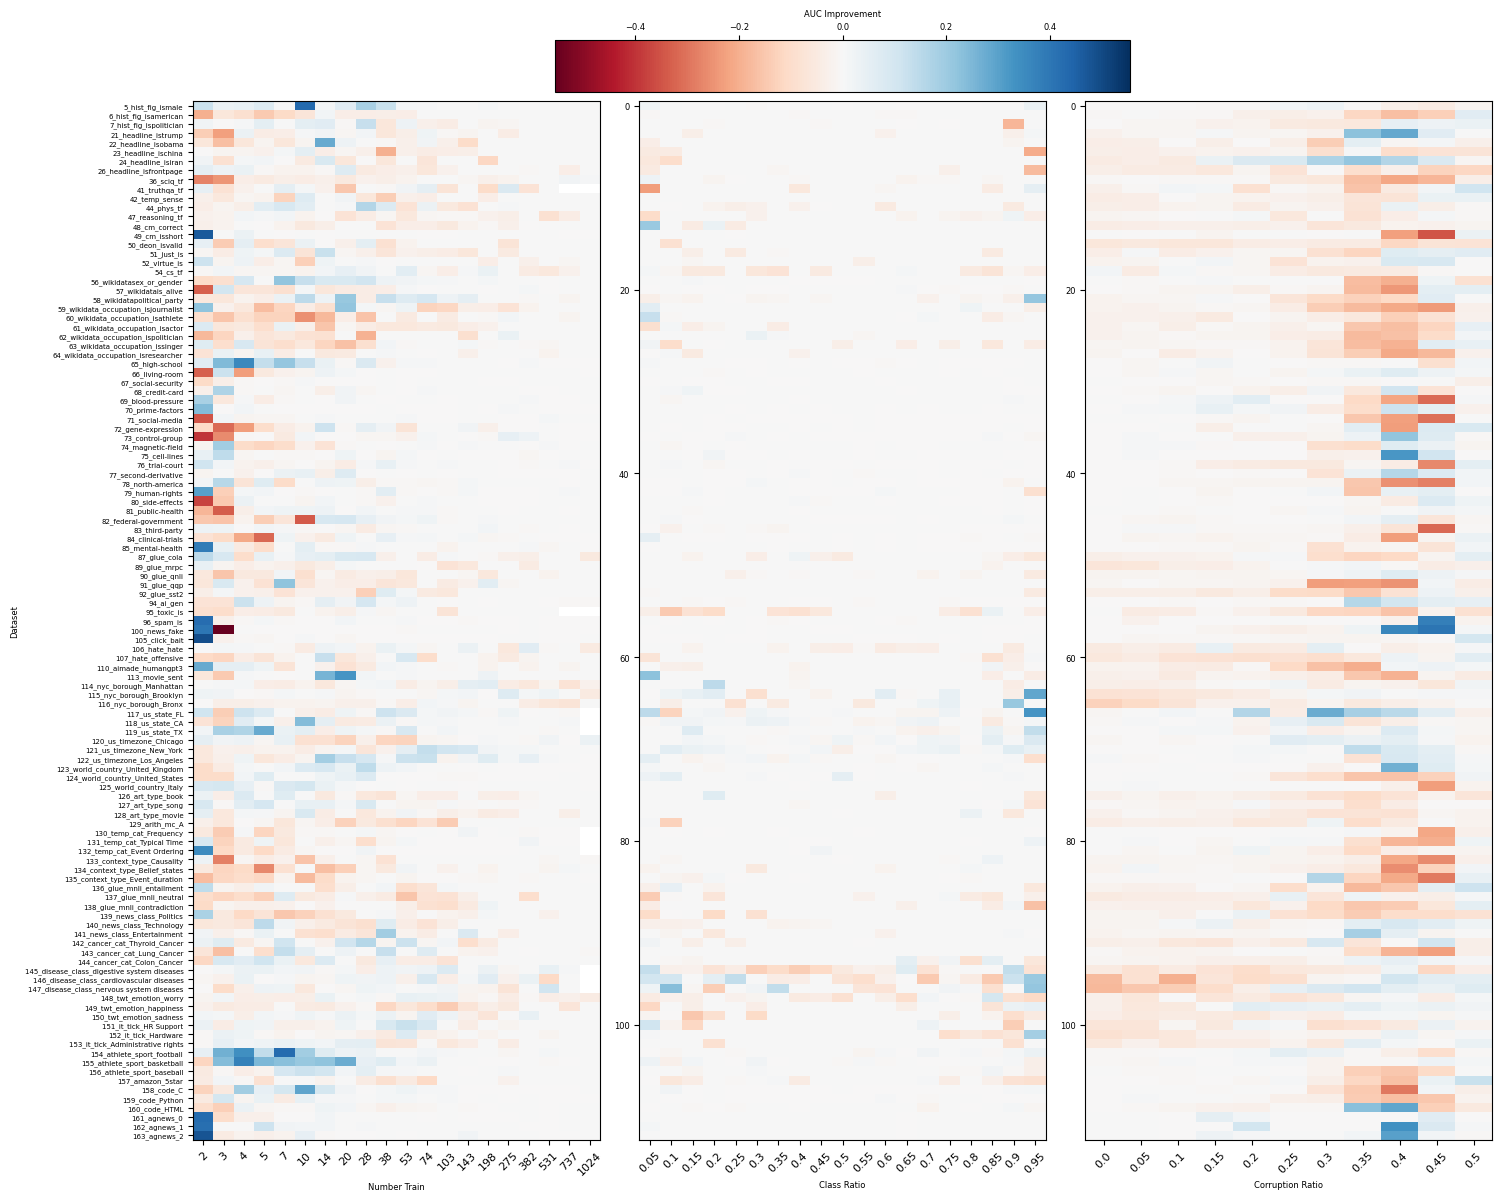

In [36]:
def plot_imshow():
    # Setup data for all three panels
    panel_configs = [
        ('scarcity', quiver_arrows_scarcity, 'num_train', 'Number Train'),
        ('imbalance', quiver_arrows_imbalance, 'ratio', 'Class Ratio'),
        ('corrupt', quiver_arrows_corrupt, 'ratio', 'Corruption Ratio')
    ]
    
    # Create figure with space for colorbar at top
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(2, 3, height_ratios=[0.05, 1])
    
    # Create colorbar axis at top
    cbar_ax = fig.add_subplot(gs[0, :])
    # Create main plot axes
    axes = [fig.add_subplot(gs[1, i]) for i in range(3)]
    
    # Store all deltas to compute global min/max
    all_deltas = []
    
    # First pass to compute deltas and collect values for colorbar scaling
    for setting, quiver_fn, col_name, _ in panel_configs:
        df_sae = quiver_fn(sae=True)
        df_no_sae = quiver_fn(sae=False)
        
        pivot_sae = df_sae.pivot(index='dataset', columns=col_name, values='test_auc')
        pivot_no_sae = df_no_sae.pivot(index='dataset', columns=col_name, values='test_auc')
        delta = pivot_sae - pivot_no_sae
        
        # Sort datasets by their numeric prefix
        datasets = delta.index.tolist()
        datasets.sort(key=lambda x: int(x.split('_')[0]))
        delta = delta.reindex(datasets)
        
        all_deltas.append(delta)
    
    # Compute global min/max for consistent colorbar
    all_vals = np.concatenate([d.values[~np.isnan(d.values)] for d in all_deltas])
    vmax = max(abs(np.min(all_vals)), abs(np.max(all_vals)))
    
    # Second pass to create plots
    for i, ((setting, quiver_fn, col_name, xlabel), delta, ax) in enumerate(zip(panel_configs, all_deltas, axes)):
        im = ax.imshow(delta, cmap='RdBu', aspect='auto', vmin=-vmax, vmax=vmax)
        
        # Set labels
        ax.set_xlabel(xlabel)
        if i == 0:
            ax.set_ylabel('Dataset')
        
        # Set ticks
        unique_vals = sorted(quiver_fn(sae=True)[col_name].unique())
        ax.set_xticks(range(len(unique_vals)))
        ax.set_xticklabels(unique_vals, rotation=45, fontsize=8)
        
        if i == 0:  # Only set y-ticks for first panel
            ax.set_yticks(range(len(datasets)))
            ax.set_yticklabels(datasets, fontsize=5)
    
    # Add colorbar at top
    cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal', label='AUC Improvement')
    cbar.ax.set_aspect(0.1)  # Make colorbar shorter/thinner
    cbar_ax.xaxis.set_ticks_position('top')
    cbar_ax.xaxis.set_label_position('top')
    
    plt.tight_layout()
    savename = f'figures/combined/dataset_imshow_combined'
    os.makedirs('figures/combined', exist_ok=True)
    plt.savefig(f'{savename}.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f'{savename}.png', dpi=300, bbox_inches='tight')

plot_imshow()

# Understanding which SAE probe is chosen most often (k = 16 or 128)
Useful for rebuttal

In [37]:
funcs = [quiver_arrows_imbalance, quiver_arrows_scarcity]
for func in funcs:
    df = func(sae = True)
    print(len(df))
    methods = df['method'].unique()
    nums = {16:0, 128:0}
    for method in methods:
        if method[:3] == 'sae':
            num = int(method.split('_')[-1][1:])
            nums[num] += len(df[df['method'] == method])
    summ = sum(nums.values())
    nums = {k: f"{(v/summ)*100:.1f}%" for k,v in nums.items()}
    print(nums)


2147
{16: '15.9%', 128: '84.1%'}
2247
{16: '23.0%', 128: '77.0%'}


In [38]:
df = quiver_arrows_imbalance(sae = True)
print(len(df))
methods = df['method'].unique()
print(methods)

2147
['sae_layer_20/width_16k/average_l0_408_k128'
 'sae_layer_20/width_16k/average_l0_408_k16'
 'sae_layer_20/width_1m/average_l0_193_k128'
 'sae_layer_20/width_131k/average_l0_276_k128'
 'sae_layer_20/width_1m/average_l0_193_k16'
 'sae_layer_20/width_131k/average_l0_276_k16' 'pca' 'mlp' 'xgboost' 'knn'
 'logreg']


# Plotting which SAE is chosen at various thresholds in different regimes
Fig. 17

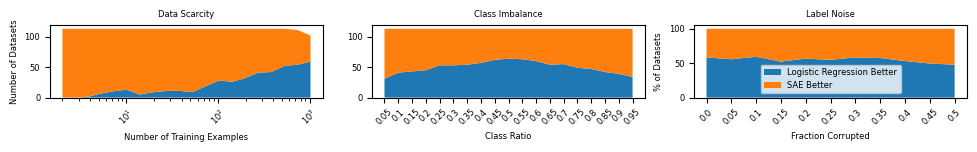

In [39]:
def plot_stack():
    fig, axes = plt.subplots(1, 3, figsize=(9.75, 1.5))
    plt.subplots_adjust(wspace=0.3)
    
    quiver_funcs = [quiver_arrows_scarcity, quiver_arrows_imbalance, quiver_arrows_corrupt]
    x_labels = ['Number of Training Examples', 'Class Ratio', 'Corruption Ratio']
    titles = ['Data Scarcity', 'Class Imbalance', 'Label Noise']
    pivot_cols = ['num_train', 'ratio', 'ratio']
    
    # First two plots - same as before
    for i, (quiver_fn, xlabel, title, pivot) in enumerate(zip(quiver_funcs[:2], x_labels[:2], titles[:2], pivot_cols[:2])):
        df_sae = quiver_fn(sae=True)
        pivot_values = sorted(df_sae[pivot].unique())
        sae_counts = []
        no_sae_counts = []
        
        for val in pivot_values:
            subset = df_sae[df_sae[pivot] == val]
            sae_count = subset[subset['method'].str.contains('sae')].shape[0]
            no_sae_count = subset[~subset['method'].str.contains('sae')].shape[0]
            sae_counts.append(sae_count)
            no_sae_counts.append(no_sae_count)
        
        axes[i].stackplot(pivot_values, [no_sae_counts, sae_counts],
                         labels=['Non SAE Chosen', 'SAE Chosen'])
        axes[i].set_xlabel(xlabel)
        if i == 0:
            axes[i].set_ylabel('Number of Datasets')
        axes[i].set_xticks(pivot_values)
        axes[i].set_xticklabels(pivot_values, rotation=45)
        axes[i].set_title(title)
        if pivot == 'num_train':
            axes[i].set_xscale('log')
    
    # Third plot - percentage of SAE wins vs losses
    df_sae = quiver_arrows_corrupt(sae=True)
    df = quiver_arrows_corrupt(sae=False)
    
    ratios = sorted(df_sae['ratio'].unique())
    sae_wins = []
    sae_losses = []
    
    for ratio in ratios:
        sae_subset = df_sae[df_sae['ratio'] == ratio]
        df_subset = df[df['ratio'] == ratio]
        
        win_count = sum(sae_subset['test_auc'].iloc[i] > df_subset['test_auc'].iloc[i] 
                       for i in range(len(sae_subset)))
        total = len(sae_subset)
        
        sae_wins.append(win_count)
        sae_losses.append(total - win_count)
    
    total_datasets = np.array(sae_wins) + np.array(sae_losses)
    sae_win_pct = 100 * np.array(sae_wins) / total_datasets
    sae_loss_pct = 100 * np.array(sae_losses) / total_datasets
    
    axes[2].stackplot(ratios, [sae_loss_pct, sae_win_pct],
                     labels=['Logistic Regression Better', 'SAE Better'])
    axes[2].set_xlabel('Fraction Corrupted')
    axes[2].set_ylabel('% of Datasets')
    axes[2].legend()
    axes[2].set_xticks(ratios)
    axes[2].set_xticklabels(ratios, rotation=45)
    axes[2].set_title(titles[2])

    plt.tight_layout()
    savename = f'figures/combined/stack_combined'
    os.makedirs('figures/combined', exist_ok=True)
    plt.savefig(f'{savename}.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f'{savename}.png', dpi=300, bbox_inches='tight')

plot_stack()

# Plot scarcity, imbalance, and corrupt select datasets and average trends
Fig. 5

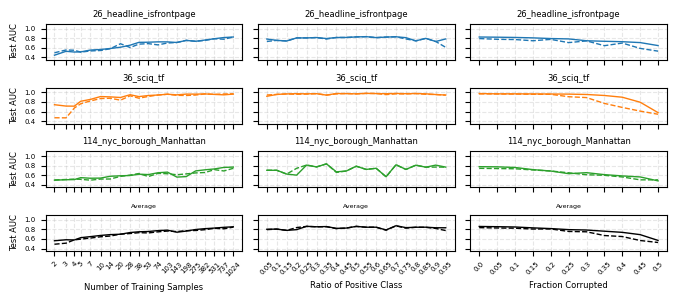

In [40]:
target_datasets = ['26_headline_isfrontpage', '36_sciq_tf', '114_nyc_borough_Manhattan', '149_twt_emotion_happiness', '155_athlete_sport_basketball']

def plot_dataset_results(k=5):
    # Define font sizes
    yaxis_font = 6  # Increased y-axis font
    xaxis_font = 6  # Increased x-axis font 
    xtick_font = 5
    title_font = 6  # Increased title font size further
    lw = 1
    posx = 0.03
    posy = 0.03

    # Take first k datasets
    plot_datasets = target_datasets[:k]

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # blue, orange, green, red, purple
    fig, axs = plt.subplots(k+1, 3, figsize=(6.75, 3), sharex='col', sharey=True)
    plt.subplots_adjust(hspace=0.2, wspace=0.3)  # Reduced vertical spacing
    style = ['--', '-']
    sortbys = ['num_train', 'ratio', 'ratio']
    
    # Column titles
    col_titles = ['Data Scarcity', 'Class Imbalance', 'Label Noise']
    quiver_funcs = [quiver_arrows_scarcity, quiver_arrows_imbalance, quiver_arrows_corrupt]

    # Plot individual datasets
    for i, dataset in enumerate(plot_datasets):
        for col, (title, quiver_func) in enumerate(zip(col_titles, quiver_funcs)):
            sortby = sortbys[col]
            axs[i, col].grid(True, linestyle='--', alpha=0.3, which='both') 
            if col == 0:  # Only set ylabel for first column
                axs[i,col].set_ylabel('Test AUC', fontsize=yaxis_font)
                axs[i,col].set_xscale('log', base=2)  # Set log scale for first column
                axs[i,col].set_yticks([0.4, 0.6, 0.8, 1.0])
                axs[i,col].set_yticklabels(['0.4', '0.6', '0.8', '1.0'], fontsize=xtick_font)
            if col != 0:
                axs[i, col].set_yticks([])
                
            # Add grid
            #axs[i,col].grid(True, linestyle='--', alpha=0.3, axis='y')
            #axs[k,col].grid(True, linestyle='--', alpha=0.3, axis='x')
                
            for j, sae in enumerate([True, False]):
                df = quiver_func(sae=sae)
                dataset_df = df[df['dataset'] == dataset]
                dataset_df = dataset_df.sort_values(sortby)
                
                axs[i,col].plot(dataset_df[sortby], dataset_df['test_auc'],
                        color=colors[i], alpha=1, linestyle=style[j], linewidth=lw)
                
            axs[i,col].set_xticks(dataset_df[sortby])
            axs[i,col].set_xticklabels([str(x) for x in dataset_df[sortby]], 
                                      rotation=45, fontsize=xtick_font)

            # Set dataset name as title for each plot with reduced padding
            axs[i,col].set_title(dataset, fontsize=title_font, pad=5)
            
            axs[i,col].set_ylim(0.35,1.1)

    # Plot averages in bottom row
    for col, (title, quiver_func) in enumerate(zip(col_titles, quiver_funcs)):
        sortby = sortbys[col]
        if col == 0:  # Only set ylabel for first column
            axs[k,col].set_ylabel('Test AUC', fontsize=yaxis_font)
            axs[k,col].set_xscale('log', base=2)  # Set log scale for first column
            axs[k,col].set_yticks([0.4, 0.6, 0.8, 1.0])
            axs[k,col].set_yticklabels(['0.4', '0.6', '0.8', '1.0'], fontsize=xtick_font)
        
        # Add grid
        axs[k,col].grid(True, linestyle='--', alpha=0.3, axis='y')
        axs[k,col].grid(True, linestyle='--', alpha=0.3, axis='x')
            
        for j, sae in enumerate([True, False]):
            df = quiver_func(sae=sae)
            df = df[df['dataset'].isin(plot_datasets)]
            
            avg_df = df.groupby(sortby)['test_auc'].mean().reset_index()
            avg_df = avg_df.sort_values(sortby)
            
            axs[k,col].plot(avg_df[sortby], avg_df['test_auc'],
                    color='black', alpha=1, linestyle=style[j], linewidth=lw)
        
        axs[k,col].set_xticks(avg_df[sortby])
        axs[k,col].set_xticklabels([str(x) for x in avg_df[sortby]], 
                                  rotation=45, fontsize=xtick_font)
        
        # Set x-label for bottom row
        xlabel = 'Number of Training Samples' if col == 0 else \
                'Ratio of Positive Class' if col == 1 else 'Fraction Corrupted'
        axs[k,col].set_xlabel(xlabel, fontsize=xaxis_font)
        
        # Set "Average" title for bottom row plots with reduced padding
        axs[k,col].set_title('Average', fontsize=title_font-1.5, pad=5)
    plt.tight_layout()
    savename = f'figures/combined/target_datasets_quiver_combined'
    os.makedirs('figures/combined', exist_ok=True)
    plt.savefig(f'{savename}.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f'{savename}.png', dpi=300, bbox_inches='tight')

plot_dataset_results(k=3)

# Average delta between SAE and baseline AUC with quiver of arrows approach
Through scarcity, imbalance, and corrupt regimes. Fig. 6

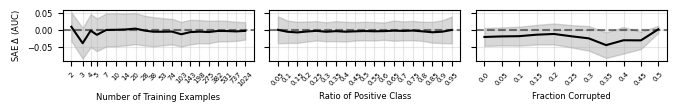

In [41]:
def plot_regime_improvements():
    fig, axs = plt.subplots(1, 3, figsize=(6.75, 1.1), sharey=True)
    
    # Define settings for each regime
    regimes = [
        ('num_train', quiver_arrows_scarcity, 'Number of Training Examples', True),
        ('ratio', quiver_arrows_imbalance, 'Ratio of Positive Class', False),
        ('ratio', quiver_arrows_corrupt, 'Fraction Corrupted', False)
    ]
    
    for i, (x_var, quiver_func, xlabel, use_log) in enumerate(regimes):
        # Get data for both SAE and non-SAE
        df_sae = quiver_func(sae=True)
        df_no_sae = quiver_func(sae=False)
        
        # Calculate statistics
        sae_stats = df_sae.groupby(x_var).agg(
            mean=('test_auc', 'mean'),
            se=('test_auc', lambda x: x.std() / np.sqrt(len(x)))
        ).reset_index()
        
        no_sae_stats = df_no_sae.groupby(x_var).agg(
            mean=('test_auc', 'mean'),
            se=('test_auc', lambda x: x.std() / np.sqrt(len(x)))
        ).reset_index()
        
        # Calculate delta and error
        delta = sae_stats['mean'] - no_sae_stats['mean']
        error = np.sqrt(sae_stats['se']**2 + no_sae_stats['se']**2)
        
        # Plot
        axs[i].plot(sae_stats[x_var], delta, 'k-')
        axs[i].fill_between(sae_stats[x_var],
                         delta - 1.96*error,
                         delta + 1.96*error,
                         color='gray', alpha=0.3)
        
        # Set scales and ticks
        if use_log:
            axs[i].set_xscale('log', base=2)
        axs[i].set_xticks(sae_stats[x_var])
        axs[i].set_xticklabels([str(x) for x in sae_stats[x_var]], rotation=45, fontsize=5)
        
        # Labels and styling
        axs[i].set_xlabel(xlabel)
        if i == 0:
            axs[i].set_ylabel(r'SAE $\Delta$ (AUC)')
        axs[i].axhline(y=0, color='k', linestyle='--', alpha=0.5)
        axs[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    savename = f'figures/combined/quiver_improve_regimes'
    plt.savefig(f'{savename}.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f'{savename}.png', dpi=300, bbox_inches='tight')

plot_regime_improvements()

# Fig 1 Bar Chart

In [42]:
def read_results_normal(layer = 20, method = 'logreg'):
    df = pd.read_csv(f'results/baseline_probes_gemma-2-9b/normal_settings/layer{layer}_results.csv')
    return df[df['method'] == method]

def read_saes_normal():
    #df = pd.read_csv('results/sae_probes_gemma-2-9b/normal_setting/l1_layer20_max_l0.csv')
    df = pd.read_csv('results/sae_probes_gemma-2-9b/normal_setting/all_metrics.csv')
    df = df[df['sae_id'].str.contains('width_16k/average_l0_408')]
    df = df[df['k'] == 128]
    df = df[df['reg_type'] == 'l1']

    #df['method'] = 'sae_16k_k128_' + df['sae_l0'].astype(str) + 'l0'
    #df = df[['test_f1', 'test_acc', 'test_auc', 'val_auc', 'dataset', 'method']]
    return df

read_saes_normal()

,test_f1,test_acc,test_auc,val_auc,k,dataset,layer,sae_id,reg_type,binarize
257,0.884061,0.884103,0.931805,0.956344,128,61_wikidata_occupation_isactor,20,layer_20/width_16k/average_l0_408,l1,False
407,0.881050,0.881141,0.939723,0.967187,128,22_headline_isobama,20,layer_20/width_16k/average_l0_408,l1,False
507,0.985188,0.985189,0.998932,1.000000,128,66_living-room,20,layer_20/width_16k/average_l0_408,l1,False
587,0.645783,0.645786,0.705079,0.773509,128,54_cs_tf,20,layer_20/width_16k/average_l0_408,l1,False
1817,0.698110,0.698305,0.759666,0.847424,128,149_twt_emotion_happiness,20,layer_20/width_16k/average_l0_408,l1,False
...,...,...,...,...,...,...,...,...,...,...
37327,0.988046,0.988046,0.997524,1.000000,128,79_human-rights,20,layer_20/width_16k/average_l0_408,l1,False
37497,0.853873,0.853994,0.940896,0.889156,128,24_headline_isiran,20,layer_20/width_16k/average_l0_408,l1,False
37797,0.850970,0.851069,0.925685,0.947979,128,92_glue_sst2,20,layer_20/width_16k/average_l0_408,l1,False
37867,0.999080,0.999080,0.999726,1.000000,128,70_prime-factors,20,layer_20/width_16k/average_l0_408,l1,False


In [43]:
def get_ood_data():
    df = pd.read_csv('results/baseline_probes_gemma-2-9b/ood/all_results.csv')
    # Extract numbers from dataset names and sort
    df['num'] = df['dataset'].str.extract('(\d+)').astype(int)
    df = df.sort_values('num')
    df = df.drop('num', axis=1)
    return df

def read_results_ood():
    df = get_ood_data()
    df['test_auc'] = df['test_auc_baseline']
    return df

def read_saes_ood():
    df = get_ood_data()
    df['test_auc'] = df['test_auc_sae']
    return df

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2606692/3904514523.py:4: SyntaxWarning: invalid escape sequence '\d'
  df['num'] = df['dataset'].str.extract('(\d+)').astype(int)


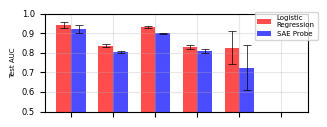

In [44]:
def plot_bar_comparison():
    # Set up figure
    fig, ax = plt.subplots(figsize=(3.25, 1.25))
    
    settings = ['normal', 'scarcity', 'imbalance', 'corrupt', 'ood', 'interp']
    width = 0.35  # Width of bars
    
    x = np.arange(len(settings))  # X coordinates for groups
    
    baseline_means = []
    sae_means = []
    baseline_ses = []
    sae_ses = []
    
    # Collect data for all settings
    for setting in settings:
        # Read data using specific functions for each setting
        if setting == 'normal':
            df_sae = read_saes_normal()
            df_baseline = read_results_normal(method = 'logreg')
        elif setting == 'scarcity':
            df_sae = read_saes_scarcity(saeid = '16k')
            df_baseline = read_results_scarcity(method = 'logreg')
        elif setting == 'imbalance':
            df_sae = read_sae_imbalance(saeid = '16k')
            df_baseline = read_results_imbalance(method = 'logreg')
        elif setting == 'corrupt':
            df_sae = read_sae_corrupt()
            df_baseline = read_results_corrupt(method = 'logreg')
        elif setting == 'ood':
            df_sae = read_saes_ood()
            df_baseline = read_results_ood()
        elif setting == 'interp':
            # Skip data collection for interp but maintain spacing
            baseline_means.append(0)  # Use 0 instead of nan to show gap
            sae_means.append(0)
            baseline_ses.append(0)
            sae_ses.append(0)
            continue
        
        # Calculate means
        baseline_means.append(df_baseline['test_auc'].mean())
        sae_means.append(df_sae['test_auc'].mean())
        
        # Calculate 95% standard errors
        baseline_ses.append(1.96 * df_baseline['test_auc'].std() / np.sqrt(len(df_baseline)))
        sae_ses.append(1.96 * df_sae['test_auc'].std() / np.sqrt(len(df_sae)))
    
    # Plot grouped bars
    ax.bar(x - width/2, baseline_means, width, color='red', alpha=0.7, label='Logistic\nRegression')
    ax.bar(x + width/2, sae_means, width, color='blue', alpha=0.7, label='SAE Probe')
    
    # Add error bars with smaller cap width and line width
    ax.errorbar(x - width/2, baseline_means, yerr=np.array(baseline_ses), 
                color='black', capsize=3, capthick=0.5, linewidth=0.5, fmt='none')
    ax.errorbar(x + width/2, sae_means, yerr=np.array(sae_ses), 
                color='black', capsize=3, capthick=0.5, linewidth=0.5, fmt='none')
    
    # Customize plot
    #ax.set_xticks(x)
    labels = ['Standard\nConditions', 'Data\nScarcity', 'Class\nImbalance', 'Label\nNoise', 'OOD', 'Interpretability']
    #ax.set_xticklabels(labels)
    ax.set_xticklabels([])
    ax.set_ylabel('Test AUC', fontsize = 5)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1.05), loc='upper right',fontsize = 5)
    plt.ylim(0.5,1)
    
    plt.tight_layout()
    savename = 'figures/combined/bar_comparison'
    plt.savefig(f'{savename}.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f'{savename}.png', dpi=300, bbox_inches='tight')

plot_bar_comparison()
